# Boilerplate

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.precision', 2)
pd.set_option('display.float_format',  '{:,.2f}'.format)

In [2]:
# kpi_raw = pd.read_csv('../data/CSU_KPI_raw_2022-01-01_2025-01-15.csv')
kpi_raw = pd.read_csv('../data/CSU_KPI_raw_2022-01-01_2025-02-07.csv')

tiktok_raw = pd.read_csv('../data/CSU_data_tiktok_raw_2024-01-15.csv')
meta_raw = pd.read_csv('../data/CSU_data_meta_raw_2024-01-15.csv')
google_raw = pd.read_csv('../data/CSU_data_google_raw_2024-01-15.csv')
bing_raw = pd.read_csv('../data/CSU_data_bing_raw_2024-01-15.csv')
ttd_raw = pd.read_csv('../data/CSU_data_TTD_raw_2024-01-15.csv')
linkedin_raw = pd.read_csv('../data/CSU_data_linkedin_raw_2024-01-15.csv')

rev_map_raw = pd.read_excel('../data/Average revenue per application per week.xlsx')

# Process KPIs

## wrangle KPIs

In [3]:
# list_awareness = ['GREENVLL-SPART-ASHEVLL-AND', 'GREENWOOD-GREENVILLE', 'JACKSONVILLE', 'ORLANDO-DAYTONA BCH-MELBRN', 'BIRMINGHAM (ANN AND TUSC)']
list_awareness = ['GREENVLL-SPART-ASHEVLL-AND', 'JACKSONVILLE', 'ORLANDO-DAYTONA BCH-MELBRN', 'BIRMINGHAM (ANN AND TUSC)']

df_kpi_full = kpi_raw.copy()
df_kpi_full['leaddate'] = pd.to_datetime(df_kpi_full['leaddate']).dt.normalize()
df_kpi_full['appdate'] = pd.to_datetime(df_kpi_full['appdate']).dt.normalize()
df_kpi_full['enrolldate'] = pd.to_datetime(df_kpi_full['enrolldate']).dt.normalize()

df_kpi_full['model'] = None
df_kpi_full.loc[df_kpi_full['dmaname'].str.match('|'.join(list_awareness), na=False), 'model'] = 'awareness'
df_kpi_full.loc[df_kpi_full['dmaname'].str.contains('MOBILE-PENSACOLA', na=False), 'model'] = 'mobile'
df_kpi_full.loc[df_kpi_full['model'].isna(), 'model'] = 'national'
df_kpi_full = df_kpi_full.loc[df_kpi_full['leaddate'] < pd.Timestamp.today()].drop(['dmaname'], axis=1) 

df_kpi_full['channel'] = None
df_kpi_full.loc[df_kpi_full['dw_channel'].str.contains('PPL'), 'channel'] = 'PPL'
df_kpi_full.loc[df_kpi_full['channel'].isna(), 'channel'] = 'ALL(No PPL,Referral)' #NO PPL BUT Everything else
df_kpi_full = df_kpi_full.loc[df_kpi_full.leaddate < '2025-01-10'] ##keeping with saturday-friday

df_kpi_cohort = df_kpi_full.loc[df_kpi_full.model != 'mobile'].copy()
df_kpi_cohort = df_kpi_cohort.loc[df_kpi_full.channel != 'PPL'].copy()

df_kpi_cohort = df_kpi_cohort[['leaddate','n_lead','n_app','model']].reset_index(drop=True)

df_kpi_cohort = df_kpi_cohort.groupby(['leaddate','model']).agg(n_app=('n_app','sum'), n_lead=('n_lead','sum'))
df_kpi_daily = df_kpi_cohort.unstack('model').fillna(0)
df_kpi_weekly = df_kpi_daily.resample('W-Sat').sum()
df_kpi_weekly.index.name='date'
# df_kpi_weekly = df_kpi_weekly.droplevel(0, axis=1)
# df_kpi_weekly = df_kpi_weekly.reset_index(drop=False)
# df_kpi_weekly = df_kpi_weekly.rename(columns={'leaddate':'date'})

model_name, model_kpi = 'awareness', 'n_lead'

dict_models = {}
dict_models[model_name] = df_kpi_weekly[(model_kpi, model_name)].copy()
dict_models[model_name] = pd.DataFrame(dict_models[model_name]) 
dict_models[model_name].columns = [model_kpi]
dict_models[model_name] = dict_models[model_name].reset_index(drop=False)

# dict_models['awareness'] = dict_models['awareness'].rename(columns={'awareness':'n_app'})
# dict_models['awareness'].columns.name=None

model_name, model_kpi = 'national', 'n_app'

dict_models[model_name] = df_kpi_weekly[(model_kpi, model_name)].copy()
dict_models[model_name] = pd.DataFrame(dict_models[model_name]) 
dict_models[model_name].columns = [model_kpi]
dict_models[model_name] = dict_models[model_name].reset_index(drop=False)

In [68]:
dict_models['national']

,date,n_app
0,2022-01-01,15.00
1,2022-01-08,186.00
2,2022-01-15,195.00
3,2022-01-22,208.00
4,2022-01-29,215.00
...,...,...
154,2024-12-14,245.00
155,2024-12-21,242.00
156,2024-12-28,166.00
157,2025-01-04,253.00


In [69]:
df_rev_a

,date,revenue
0,2022-01-01,0.00
1,2022-01-08,1.30
2,2022-01-15,18.57
3,2022-01-22,72.55
4,2022-01-29,173.91
...,...,...
154,2024-12-14,"17,968.34"
155,2024-12-21,"18,151.65"
156,2024-12-28,"18,269.34"
157,2025-01-04,"18,281.74"


## Investigate lead to app 

In [4]:
df_perc = df_kpi_full.loc[df_kpi_full.model=='awareness', ['n_lead','n_app']].sum()
lead2app_awareness = df_perc['n_app']/df_perc['n_lead']

lag_hist = np.round(df_kpi_daily[('n_lead','awareness')].sub(df_kpi_daily[('n_app','awareness')]).values/7)
df_hist = pd.DataFrame({'n_wk': lag_hist})

array([[<Axes: title={'center': 'n_wk'}>]], dtype=object)

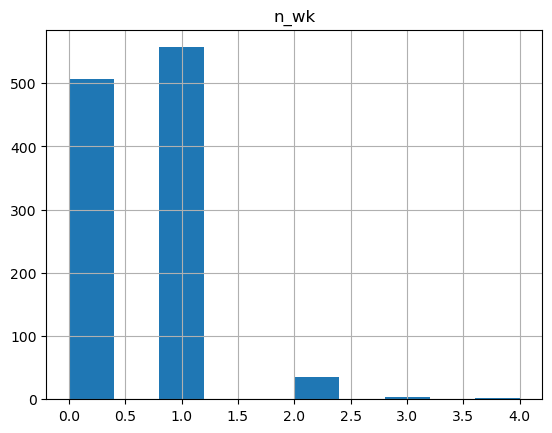

In [5]:
df_hist.hist()

In [6]:
# Ok, no real lag, so I'm not lagging the revenue further, just scaling down from app to leads.

In [7]:
lead2app_awareness

0.22142372881355932

## Get revenue

In [13]:
# def create_shifted_array(arr, shifts, n_pad=None):
def create_shifted_array(arr_in, n_size):
    """
    Creates an array containing shifted versions of the input array.

    Args:
        arr (numpy.ndarray): The input array.
        shifts (list of int): A list of integers representing the shift amounts.
        n_pad (int): how

    Returns:
        numpy.ndarray: An array where each row is a shifted version of the input array.
    """
    arr_in = arr_in.reshape(-1)
    arr = np.zeros(n_size)
    arr[:len(arr_in)] = arr_in
    arr_out = np.zeros((n_size, n_size))
    shifts = np.arange(n_size)
    for shift in shifts:
        tmp = np.roll(arr, shift)
        tmp[:shift] = 0
        arr_out[:, shift] = tmp
        #     rows.append(tmp)
    return arr_out

def calc_conv(k, v):
    k = np.array(k)
    v_out = np.array(v)
    v_out = v_out.reshape(-1)
    k_mat = create_shifted_array(k, len(v))
    conv = np.sum(k_mat*v_out, -1)
    return conv

In [52]:
rev_map_app = rev_map_raw[[2023]].copy()
rev_map_app = rev_map_app[~rev_map_app[2023].isna()]
rev_map_lead = rev_map_app.mul(lead2app_awareness)

kernel_app = rev_map_app.values.flatten() #len = 52
kernel_lead = rev_map_lead.values.flatten() #len = 52

x_val_a = np.array(dict_models['awareness']['n_lead'].values) #len = 159
x_val_n = np.array(dict_models['national']['n_app'].values) #len = 159

rev_n = calc_conv(kernel_app, x_val_n)
rev_a = calc_conv(kernel_lead, x_val_a)

df_rev_n = pd.DataFrame({'date': dict_models['national']['date'], 'revenue': rev_n})
df_rev_a = pd.DataFrame({'date': dict_models['awareness']['date'], 'revenue': rev_a})

In [64]:
# df_rev_n.to_csv('../data/national_revenue_2025-02-07.csv')
# df_rev_a.to_csv('../data/awareness_revenue_2025-02-07.csv')

## Check KPI with rev graphs

In [74]:
df_a = dict_models['awareness'].merge(df_rev_a, how='left', on='date')
df_n = dict_models['national'].merge(df_rev_n, how='left', on='date')

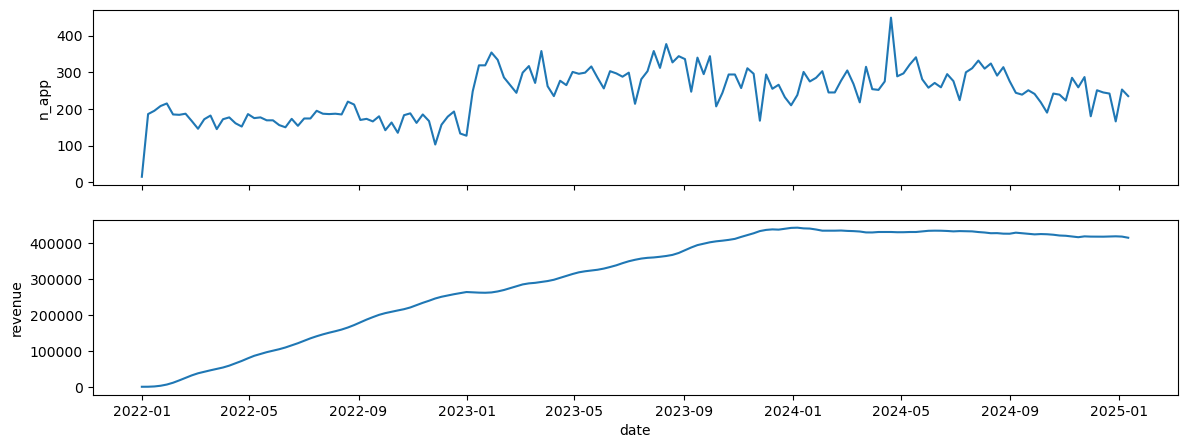

In [77]:
df_g = df_n.copy()

fig, axes = plt.subplots(2,1, figsize=(14,5), sharex=True)

sns.lineplot(data=df_g, x='date', y='n_app', ax=axes[0])
sns.lineplot(data=df_g, x='date', y='revenue', ax=axes[1]);

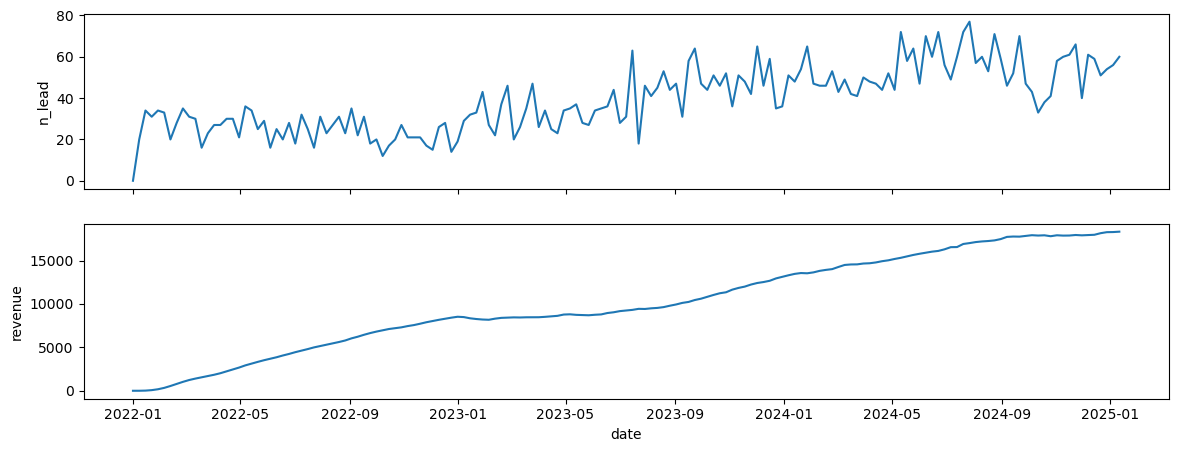

In [79]:
df_g = df_a.copy()

fig, axes = plt.subplots(2,1, figsize=(14,5), sharex=True)

sns.lineplot(data=df_g, x='date', y='n_lead', ax=axes[0])
sns.lineplot(data=df_g, x='date', y='revenue', ax=axes[1]);

In [80]:
df_a.to_csv('../data/KPI-rev_awareness_2025-02-09.csv')
df_n.to_csv('../data/KPI-rev_national_2025-02-09.csv')

# Wrangle media